# Setup

In [1]:
!pip install qiskit qiskit_ibm_runtime pylatexenc qiskit-aer

In [2]:
import qiskit as qs
import qiskit_ibm_runtime as qs_ibm
from qiskit_aer import AerSimulator
from qiskit import QuantumRegister, AncillaRegister, QuantumCircuit, ClassicalRegister, transpile
from qiskit.circuit.library import C4XGate, C3XGate
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram, array_to_latex

from qiskit_ibm_runtime import QiskitRuntimeService, Batch, Sampler

import math

In [3]:
def read_token(path:str) -> str:
  with open(path, 'r', encoding="utf-8") as src:
    token = src.readline()
    return token

Podłączenie się do serwisu IBMu i wybranego symulatora

In [4]:
service = QiskitRuntimeService(
   channel='ibm_quantum',
   instance='ibm-q/open/main',
   token=read_token('content/ibm_token.txt')
)

<ipython-input-4-a6f697f23d45>:1: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(


In [5]:
backend = AerSimulator()
print(backend.name)

aer_simulator


# Zadanie 1

Zaimplementuj i uruchom na wybranym symulatorze algorytm Grovera dla $n=2$  (z zadania domowego)

Inicjalizacja układu.

Umownie wyrocznia rozpoznaje $|10>$

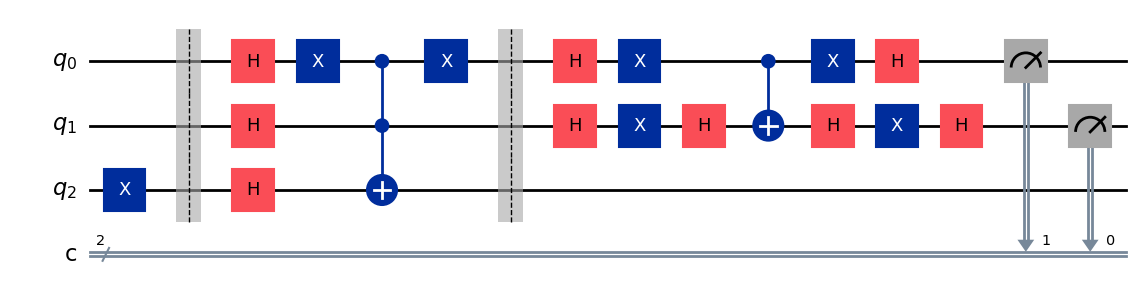

In [6]:
qc_grover_2 = QuantumCircuit(3, 2)

#lets negate the output register qubit
qc_grover_2.x(2)
qc_grover_2.barrier()

# Create the first column of hadamards
qc_grover_2.h([0,1,2])

#Create an oracle that recognizes |01>
qc_grover_2.x(0)
qc_grover_2.ccx(0,1,2)
qc_grover_2.x(0)
qc_grover_2.barrier()

# Create the diffuser
qc_grover_2.h([0,1])
qc_grover_2.x([0,1])
qc_grover_2.h(1)
qc_grover_2.cx(0,1)
qc_grover_2.h(1)
qc_grover_2.x([0,1])
qc_grover_2.h([0,1])

#measure on the 'input' register qubit that should bring us answers
qc_grover_2.measure(0, 1)
qc_grover_2.measure(1, 0)

qc_grover_2.draw(output='mpl')

Uruchomienie symulatora

In [7]:
qc_transpiled = transpile(qc_grover_2, backend, optimization_level=3, seed_transpiler=0)
with Batch(backend=backend):
    sampler = Sampler()
    job = sampler.run(
        [qc_transpiled],
        shots=256,
    )
    result_simulator = job.result()

Wyświetlenie wyników

Wynik pomiaru: {'01': 256}


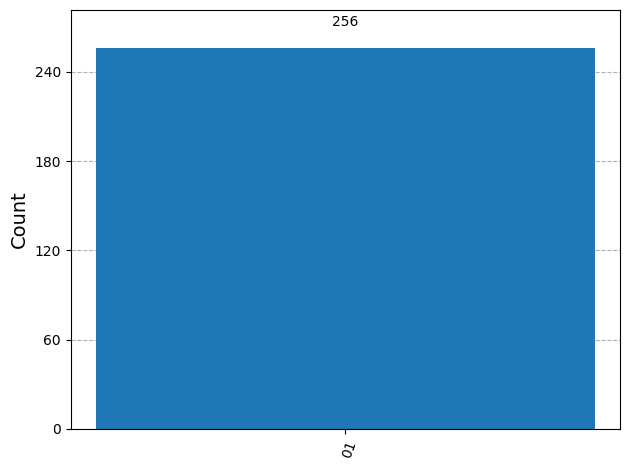

In [8]:
binary_prob = result_simulator[0].data.c.get_counts()
print("Wynik pomiaru:", binary_prob)
plot_histogram(binary_prob)

# Zadanie 2

Zaimplementuj na  wybranym symulatorze  algorytm Grovera  do rozwiązywania Sudoku. Dokładny opis zadania znajduje się w notebooku wyrocznia_sudoku (należy oglądąc wraz z obrazkiem binary_sudoku.png)

*uwaga: przetestowano z wersjami qiskita i qiskit-runtime widocznymi na dole notebooka.*

* Przedstawiony problem Sudoku ma dwa poprawne rozwiązania. Liczba iteracji to podłoga wyrażenia $$\frac{\pi}{4}\cdot \sqrt{\frac{N}{m}}$$ N - liczba wszystkich możliwości, m -liczba możliwości na tak
* rejesterem wejściowym jest <i>var_qubits</i> - przed uruchomomieniem  pierwszej iteracji Grovera należy ustawić go w stan superpozycji za pomocą bramek H (podobnie jak w zadaniu domowym).  
* Tylko na rejestrze wejściowym należy dokonać  inwersji (w odpowiednich miejscach w obwodzie)
* rejesterem wyjściowym jest  <i> output_qubit </i> przed uruchomieniem pierwszej iteracji Grovera należy ustawić go w stan  $H|1>$, (tak samo jak w zadaniu domowym)
* pozostałe rejestry są pomocnicze (ang auxilary qbits) - nie należy ich specjalnie ustawiać (na początku są standardowo ustawiane na $|0>$), ani mierzyć.


Z podanego wzoru możemy oszacować ilość koniecznych iteracji:
1. Zakładając, że w danym polu możemy wpisać $1$ lub $0$ oraz, że sudoku można wypełnić dowolną liczbą jedynek i zer otrzymujemy $2^4 = 16$ możliwości.
2. Jeśli żadna kolumna i wiersz nie mogą się składać tylko i wyłącznie z jednej cyfry, to możemy wypełnić sudoku poprawnie, tylko poprzez wpisanie tej samej cyfry po skosie, co daje nam $2$ poprawne rozwiązania.
3. Podstawmy otrzymane wartości do wzoru

In [9]:
all_possibilities = 16
correct_solutions = 2
iterations = round((math.pi/4)* math.sqrt(all_possibilities/correct_solutions))

print(f"The estimated number of iterations is = {iterations}")

The estimated number of iterations is = 2


Skorzystajmy z kodu podanego w źródle, tworzącego wyrocznię

In [10]:
clause_list = [[0,1],
               [0,2],
               [1,3],
               [2,3]]

In [11]:
def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

In [12]:
def sudoku_oracle(qc, clause_list, clause_qubits):
    # Compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    qc.append(C4XGate(),[clause_qubits[0], clause_qubits[1], clause_qubits[2], clause_qubits[3], output_qubit[0]])
    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

In [13]:
#setup of the circuit
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc_sudoku = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

Wprowadzenie wejściowych qubitów w stan superpozycji za pomocą bramek Hadamarda

In [14]:
qc_sudoku.h(var_qubits)

qc_sudoku.draw()

┌───┐
    v_0: ┤ H ├
         ├───┤
    v_1: ┤ H ├
         ├───┤
    v_2: ┤ H ├
         ├───┤
    v_3: ┤ H ├
         └───┘
    c_0: ─────
              
    c_1: ─────
              
    c_2: ─────
              
    c_3: ─────
              
    out: ─────
              
cbits: 4/═════

Wprowadzenie qubitu rejestru wyjściowego w stan $H|1>$

In [15]:
qc_sudoku.x(output_qubit)
qc_sudoku.h(output_qubit)

qc_sudoku.draw()

┌───┐     
    v_0: ┤ H ├─────
         ├───┤     
    v_1: ┤ H ├─────
         ├───┤     
    v_2: ┤ H ├─────
         ├───┤     
    v_3: ┤ H ├─────
         └───┘     
    c_0: ──────────
                   
    c_1: ──────────
                   
    c_2: ──────────
                   
    c_3: ──────────
         ┌───┐┌───┐
    out: ┤ X ├┤ H ├
         └───┘└───┘
cbits: 4/══════════

Dla odpowiedniej ilości iteracji dodajmy kolejno wyrocznię i inwersję
Pętla wykonuje tyle obiegów, ile razy trzeba „wzmocnić” poprawne odpowiedzi w superpozycji, aby znacznie zwiększyć prawdopodobieństwo ich odczytania. Ilość iteracji Grovera obliczamy ze wzoru:

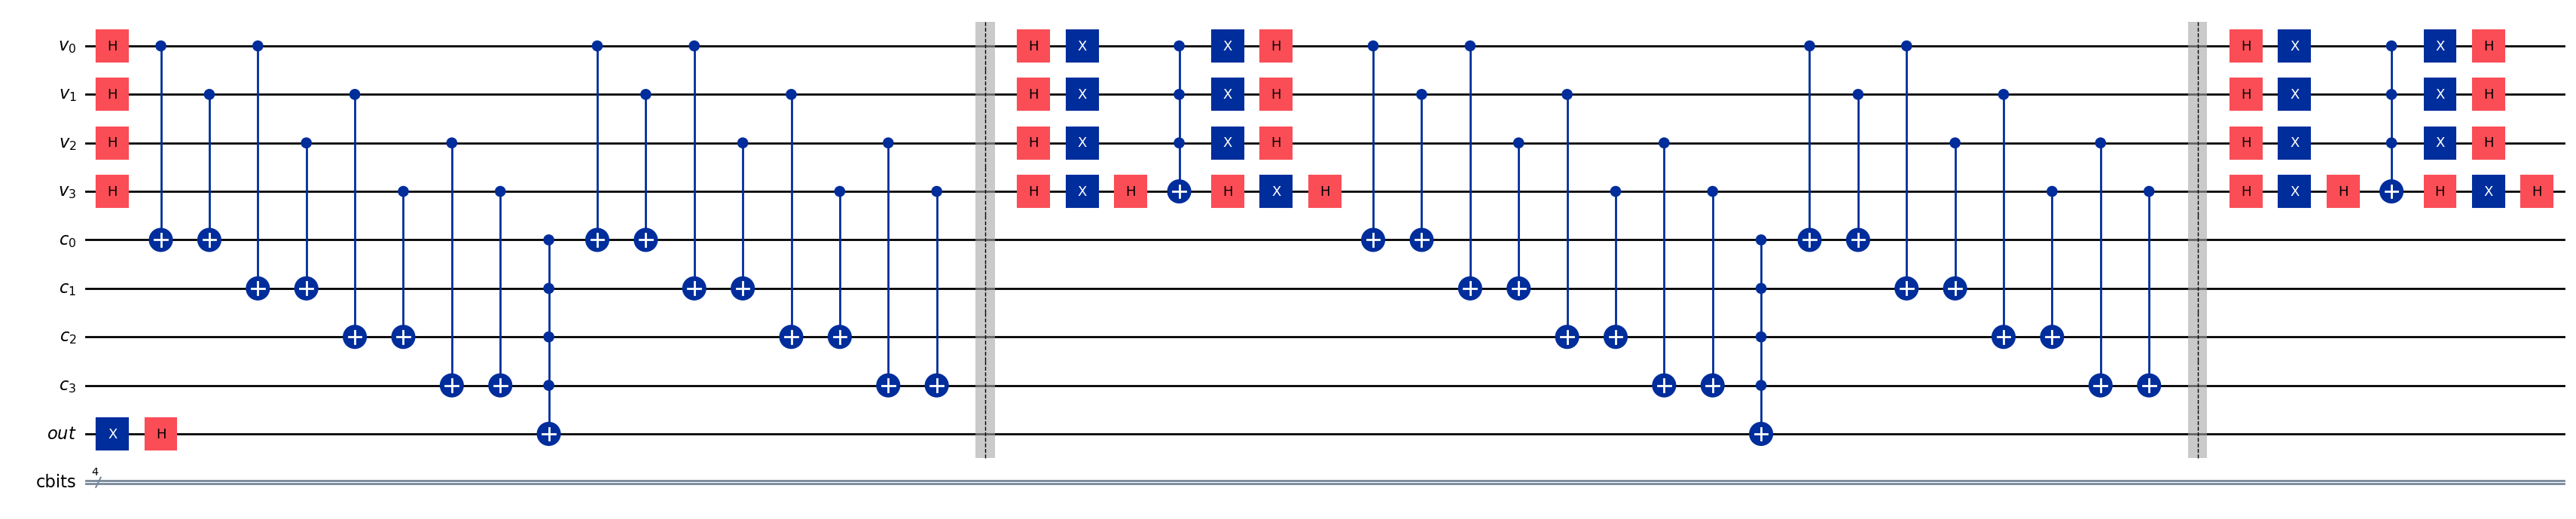

In [16]:
for i in range(iterations):
  sudoku_oracle(qc_sudoku, clause_list, clause_qubits)
  qc_sudoku.barrier()
  # Create the diffuser
  qc_sudoku.h(var_qubits)
  qc_sudoku.x(var_qubits)

  qc_sudoku.h(var_qubits[-1])
  qc_sudoku.append(C3XGate(),[*var_qubits[:-1],var_qubits[-1]])
  qc_sudoku.h(var_qubits[-1])

  qc_sudoku.x(var_qubits)
  qc_sudoku.h(var_qubits)

qc_sudoku.draw(output='mpl', fold=-1)

Dodajmy pomiary do qubitów rejestru wejściowego

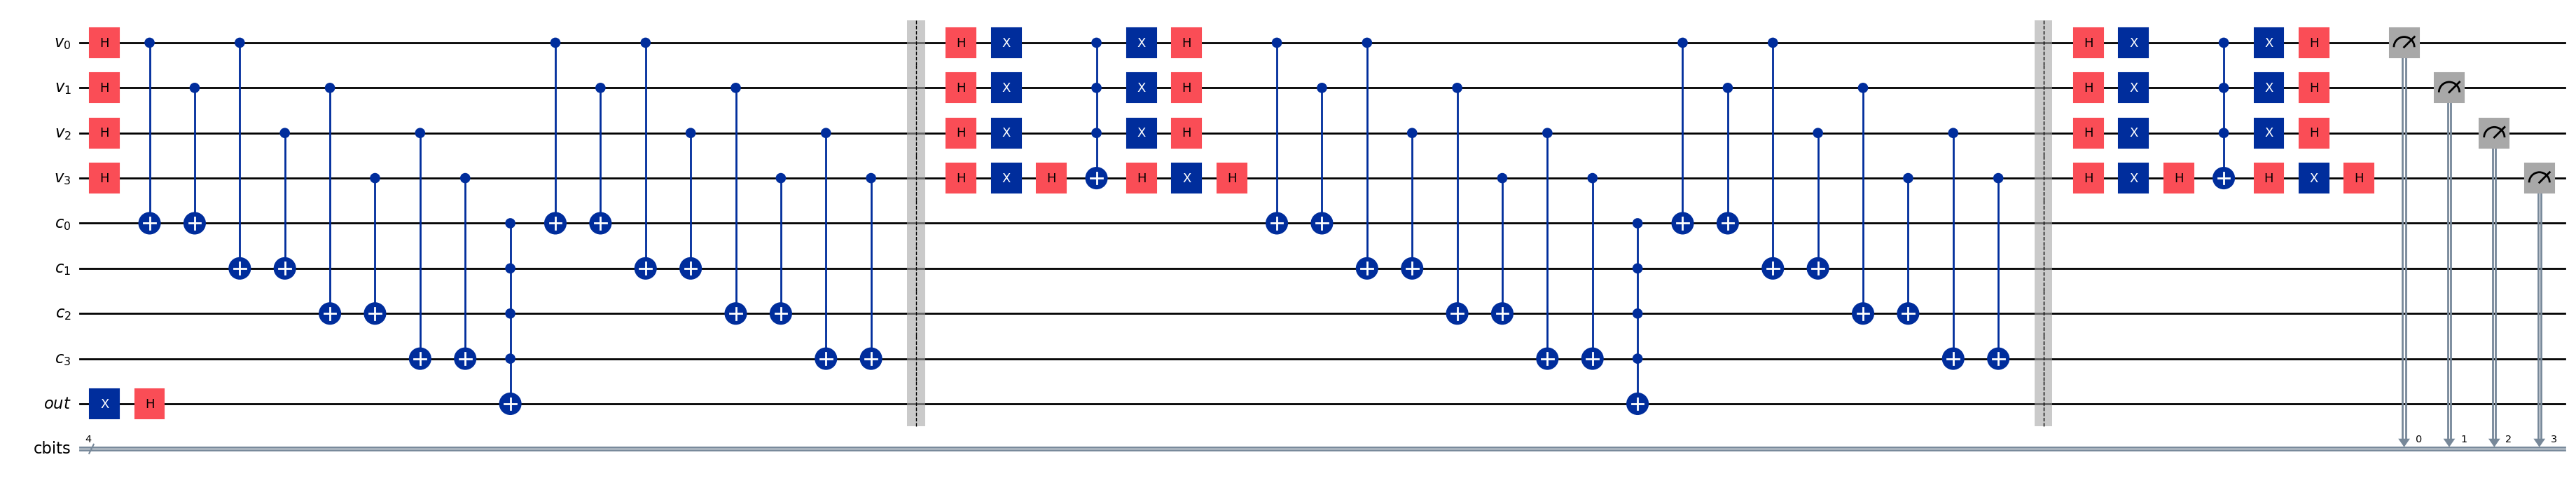

In [17]:
for i in range(4):
  qc_sudoku.measure(var_qubits[i], cbits[i])

qc_sudoku.draw(output='mpl', fold=-1)

Uruchomienie symulatora

In [18]:
transpiled_qc = transpile(qc_sudoku, backend, optimization_level=3, seed_transpiler=0)
with Batch( backend=backend):
    sampler = Sampler()
    job = sampler.run(
        [transpiled_qc],
        shots=256,
    )
    result_sudoku = job.result()

Przedstawienie wyników

Wynik pomiaru: {'0110': 127, '1001': 115, '1011': 4, '1010': 2, '1100': 2, '0101': 2, '0100': 2, '1101': 2}


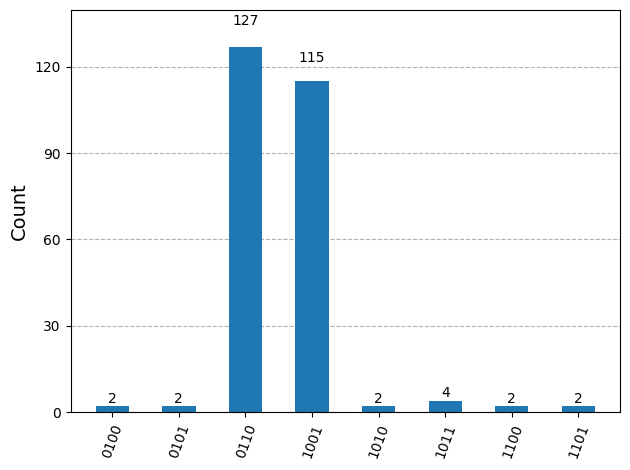

In [19]:
binary_prob = result_sudoku[0].data.cbits.get_counts()
print("Wynik pomiaru:", binary_prob)
plot_histogram(binary_prob)

Pamiętając, że najstarszy qubit ma najmniejszy index ($v_{0}$ odpowiada skrajnie lewemu qubitowi), sprawdźmy czy wynik się zgadza, czyli czy $v_{0}$ i $v_{3}$ oraz $v_{1}$ i $v_{2}$ są położone parami na skos.

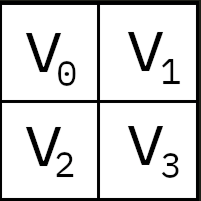

Dokładnie tak jest. Zatem udało nam się rozwiązać sudoku za pomocą algorytmu Grovera.